In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [8]:

df = pd.read_csv('/content/bank_churn.csv')
print("Dataset loaded successfully. Displaying the first 5 rows:")
df.head()

Dataset loaded successfully. Displaying the first 5 rows:


,ID,age,balance,country,credit_score,estimated_salary,gender,churn
0,0,48,96898.482195,0,654,74961.905673,0,1
1,1,62,144976.500000,0,608,175836.030000,0,1
2,2,32,0.000000,0,629,77965.440000,1,0
3,3,20,124266.860000,0,636,100566.810000,0,0
4,4,42,88844.628050,0,714,180637.273416,0,1


In [9]:
# 2. Preprocessing
# Drop ID as it's not a feature
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

In [10]:
# Separate Features and Target
X = df.drop(columns=['churn'])
y = df['churn'].values

In [21]:
# Define columns by type
categorical_cols = ['country']
numerical_cols = ['age', 'balance', 'credit_score', 'estimated_salary']
#gender is already 0/1 so we can pass it

In [22]:
#creating a preprocessor while keeping gender as it is
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)
X_processed = preprocessor.fit_transform(X)

In [23]:
#spliting the data
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)


In [24]:
# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

In [25]:
#Define Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear layer: input_dim -> 1 output
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        # We output logits (raw scores).
        # The sigmoid activation is handled by the loss function (BCEWithLogitsLoss)
        return self.linear(x)

input_dim = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_dim)

In [26]:
#Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [27]:
#Training Loop with Intermediate Evaluation
num_epochs = 500
train_losses = []
val_losses = []
val_accuracies = []

print(f"{'Epoch':<10} | {'Train Loss':<12} | {'Val Loss':<10} | {'Val Acc':<10}")
print("-" * 50)

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation Step
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

            # Calculate accuracy (sigmoid > 0.5 is class 1)
            predicted = (torch.sigmoid(val_outputs) >= 0.5).float()
            accuracy = (predicted == y_val_tensor).float().mean().item()

            # Store metrics
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
            val_accuracies.append(accuracy)

            # Print status every 50 epochs
            if (epoch + 1) % 50 == 0:
                print(f"{epoch+1:<10} | {loss.item():.4f}       | {val_loss.item():.4f}     | {accuracy:.4f}")

Epoch      | Train Loss   | Val Loss   | Val Acc   
--------------------------------------------------
50         | 0.5707       | 0.5759     | 0.7667
100        | 0.5449       | 0.5514     | 0.7667
150        | 0.5364       | 0.5433     | 0.7833
200        | 0.5333       | 0.5404     | 0.7750
250        | 0.5323       | 0.5396     | 0.7583
300        | 0.5320       | 0.5395     | 0.7583
350        | 0.5319       | 0.5396     | 0.7583
400        | 0.5319       | 0.5397     | 0.7583
450        | 0.5319       | 0.5398     | 0.7583
500        | 0.5319       | 0.5398     | 0.7583


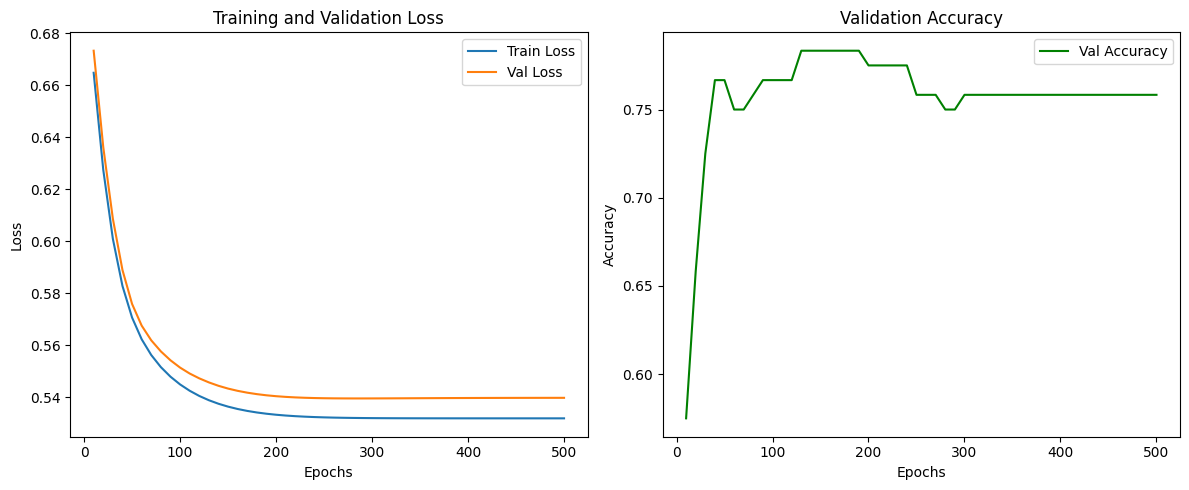

In [28]:
#Plotting Results
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
epochs_range = range(10, num_epochs + 1, 10)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()